In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn import metrics
import statsmodels.api as sm


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import backend
from tensorflow.keras.metrics import RootMeanSquaredError
from keras import regularizers
from keras.callbacks import EarlyStopping


from scipy import stats

%matplotlib inline

In [2]:
df = pd.read_csv('../../Data/final_without_duplicates.csv')
df.drop('index', axis =1, inplace = True)
df.head()

,track_ids,track_pop,track_name,artist,artist_ids,featured_artist,danceability,energy,key,loudness,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artist_pop,genre,category
0,3GJ4hzg4lrGwU51Y3VARbF,78,Speechless,Dan + Shay,7z5WFjZAIYejWy0NI5lv4T,0,0.616,0.438,1,-5.968,...,0.356,0.000000,0.2400,0.386,135.929,213387,4,85,contemporary country,country
1,2rxQMGVafnNaRaXlRMWPde,79,Beautiful Crazy,Luke Combs,718COspgdWOnwOFpJHRZHS,0,0.552,0.402,11,-7.431,...,0.676,0.000000,0.0928,0.382,103.313,193200,4,86,contemporary country,country
2,7Lr4XaxGpkAwa37IVgg22k,69,Back To Life,Rascal Flatts,0a1gHP0HAqALbEyxaD5Ngn,0,0.467,0.701,4,-4.997,...,0.191,0.000000,0.0769,0.280,132.041,214219,3,76,contemporary country,country
3,5kp3JbZL1ROMxc32pcpn29,58,Slow Dance In A Parking Lot,Jordan Davis,77kULmXAQ6vWer7IIHdGzI,0,0.519,0.833,7,-4.470,...,0.303,0.000001,0.1690,0.514,81.992,193929,4,72,contemporary country,country
4,1wPiUPw9IqSchKwinw7dCf,10,Made For You,Jake Owen,1n2pb9Tsfe4SwAjmUac6YT,0,0.541,0.452,1,-6.129,...,0.762,0.000020,0.1140,0.325,82.052,238040,4,72,contemporary country,country


In [3]:
X = df.drop(columns = ['track_ids', 'track_name', 'artist', 'artist_ids', 'genre'])
X = pd.get_dummies(X)
y = df['track_pop']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [6]:
# credit- https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [ ]:
def model_func(layer_one_neurons=32, layer_two_neurons=32):
    model = Sequential()
    
    model.add(Dense(layer_one_neurons, activation='relu', input_shape=(22,)))
    
    model.add(Dense(layer_two_neurons, activation='relu'))
    
    model.add(Dense(1, activation=None))
    
    model.compile(loss='mse', optimizer='adam', metrics = ['RootMeanSquaredError'])
    
    return model

nn = KerasRegressor(build_fn=model_func, batch_size=512, verbose=1)

params = {
    'epochs': [5,10],
    'layer_one_neurons': [32, 50, 150],
    'layer_two_neurons': [32, 12]
}

gs = GridSearchCV(nn, param_grid=params, cv=2)
gs.fit(X_train_sc, y_train)
print(gs.best_score_)
gs.best_params_

In [14]:
pred = gs.predict(X_test_sc)
print(metrics.r2_score(y_test, pred))

res = pred - y_test

SS_res = sum(res**2)
MSE = SS_res / len(res)
RMSE = np.sqrt(MSE)
print( f'The rmse test score is {RMSE}.')

3132/3132 [==============================] - 0s 13us/sample
0.7600078435597477
The rmse test score is 10.475581952262782.


Text(0.5, 1.0, 'QQ Norm Plot')

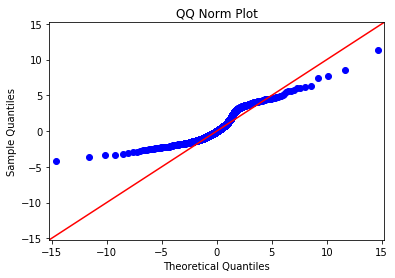

In [12]:
sm.qqplot(res ,stats.t, fit =True , line = '45');
plt.title('QQ Norm Plot')

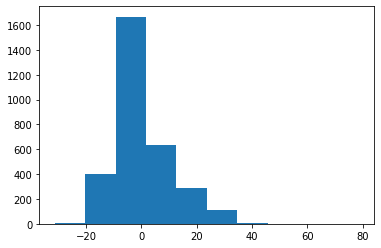

In [13]:
plt.hist(res);

### Using l2 regularization

In [ ]:
def model_func(layer_one_neurons=32, layer_two_neurons=32):
    model = Sequential()
    
    model.add(Dense(layer_one_neurons, activation='relu', input_shape=(22,), kernel_regularizer=regularizers.l2(0.01)
))
    
    model.add(Dense(layer_two_neurons, activation='relu', kernel_regularizer=regularizers.l2(0.01)
))
    
    model.add(Dense(1, activation=None))
    
    model.compile(loss='mse', optimizer='adam', metrics = ['RootMeanSquaredError'])
    
    return model

nn = KerasRegressor(build_fn=model_func, batch_size=512, verbose=1)

params = {
    'epochs': [5,10],
    'layer_one_neurons': [32, 50, 150],
    'layer_two_neurons': [32, 12]
}

gs = GridSearchCV(nn, param_grid=params, cv=2)
gs.fit(X_train_sc, y_train)
print(gs.best_score_)
gs.best_params_

In [17]:
pred2 = gs.predict(X_test_sc)
print(metrics.r2_score(y_test, pred2))

res2 = pred2 - y_test

SS_res = sum(res2**2)
MSE = SS_res / len(res2)
RMSE = np.sqrt(MSE)
print( f'The rmse test score is {RMSE}.')

3132/3132 [==============================] - 0s 10us/sample
0.7545222438256514
The rmse test score is 10.594627874639233.


### With Dropout

In [ ]:
def model_func(layer_one_neurons=32, layer_two_neurons=32):
    model = Sequential()
    
    model.add(Dense(layer_one_neurons, activation='relu', input_shape=(22,)))
    model.add(Dropout(0.5))
    model.add(Dense(layer_two_neurons, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation=None))
    
    model.compile(loss='mse', optimizer='adam', metrics = ['RootMeanSquaredError'])
    
    return model

nn = KerasRegressor(build_fn=model_func, batch_size=512, verbose=1)

params = {
    'epochs': [5,10],
    'layer_one_neurons': [32, 50, 150],
    'layer_two_neurons': [32, 12]
}

gs = GridSearchCV(nn, param_grid=params, cv=2)
gs.fit(X_train_sc, y_train)
print(gs.best_score_)
gs.best_params_

In [27]:
pred3 = gs.predict(X_test_sc)
print(metrics.r2_score(y_test, pred3))

res3 = pred3 - y_test

SS_res = sum(res3**2)
MSE = SS_res / len(res3)
RMSE = np.sqrt(MSE)
print( f'The rmse test score is {RMSE}.')

3132/3132 [==============================] - 0s 16us/sample
0.7717741816543817
The rmse test score is 10.215556290475602.


### Early stopping

In [ ]:
def model_func(layer_one_neurons=32, layer_two_neurons=32):
    model = Sequential()
    
    model.add(Dense(layer_one_neurons, activation='relu', input_shape=(22,)))
    
    model.add(Dense(layer_two_neurons, activation='relu'))
    
    model.add(Dense(1, activation=None))
    
    model.compile(loss='mse', optimizer='adam', metrics = ['RootMeanSquaredError'])
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

    return model

nn = KerasRegressor(build_fn=model_func, batch_size=512, verbose=1)

params = {
    'epochs': [5,10],
    'layer_one_neurons': [32, 50, 150],
    'layer_two_neurons': [32, 12]
}

gs = GridSearchCV(nn, param_grid=params, cv=2)
gs.fit(X_train_sc, y_train)
print(gs.best_score_)
gs.best_params_

### Final Neural Network Model

In [ ]:
def model_func(layer_one_neurons=32, layer_two_neurons=32, dropout_num = 0.5):
    model = Sequential()
    
    model.add(Dense(layer_one_neurons, activation='relu', input_shape=(22,), kernel_regularizer=regularizers.l2(0.01)
))
    model.add(Dropout(dropout_num))

    model.add(Dense(layer_two_neurons, activation='relu', kernel_regularizer=regularizers.l2(0.01)
))
    model.add(Dropout(dropout_num))

    model.add(Dense(1, activation=None))
    
    model.compile(loss='mse', optimizer='adam', metrics = ['RootMeanSquaredError'])
    
    return model

nn = KerasRegressor(build_fn=model_func, batch_size=512, verbose=1)

params = {
    'epochs': [5,10],
    'layer_one_neurons': [32, 50, 150],
    'layer_two_neurons': [32, 12],
    'dropout_num': [0.1, 0.3, 0.5]
}

gs = GridSearchCV(nn, param_grid=params, cv=2)
gs.fit(X_train_sc, y_train)
print(gs.best_score_)
gs.best_params_

In [29]:
pred_final = gs.predict(X_test_sc)
print(metrics.r2_score(y_test, pred_final))

res_final = pred_final - y_test

SS_res = sum(res_final**2)
MSE = SS_res / len(res_final)
RMSE = np.sqrt(MSE)
print( f'The rmse test score is {RMSE}.')

3132/3132 [==============================] - 0s 12us/sample
0.8080879238032244
The rmse test score is 9.367652818525457.
